# Fraud Claim Prediction from Car Insurance Data

In [1]:
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from fancyimpute import IterativeImputer, KNN
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_curve, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
# from sklearn.externals import joblib
import joblib
import warnings


Bad key "axes.color_cycle" on line 241 in
/Users/tosi-n/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
np.random.seed(1)

warnings.filterwarnings("ignore")

data = pd.read_csv("/Volumes/Loopdisk/Dev/PyDsc/jobs/insurance_claims.csv")

drop_columns = ["_c39", "auto_model", "policy_bind_date", "policy_state", "incident_date",
               "incident_state", "incident_city", "incident_location", "policy_csl"]

data = data.drop(drop_columns, axis=1)

new_response = []
response = data.iloc[:, -1]
for i in range(len(response)):
    new_response.append(1 if response[i]=='Y' else 0)

data["fraud_reported"] = pd.Series(new_response)
data = data.replace(['?'], np.NaN)

# obj_df = data.select_dtypes(include=['object']).copy()
# obj_df.head(10)

### Drop insignificant features like: 
- policy_bind_date
- policy_state
- incident_date
- auto_model
- _c39
- policy_csl

## Exploratory Data Analysis

Text(0, 0.5, 'Number of customers')

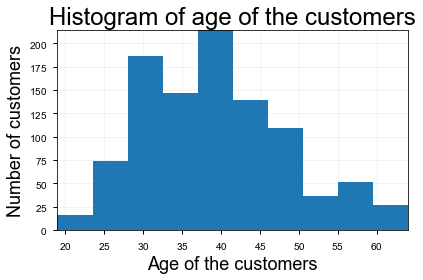

In [3]:
plt.hist(data.age)
plt.title("Histogram of age of the customers")
plt.xlabel("Age of the customers")
plt.ylabel("Number of customers")

Text(0, 0.5, 'Number of customers')

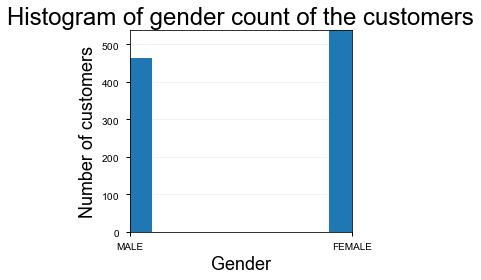

In [4]:
plt.hist(data.insured_sex)
plt.title("Histogram of gender count of the customers")
plt.xlabel("Gender")
plt.ylabel("Number of customers")

- Balanced gender class

Text(0, 0.5, 'Number of responses')

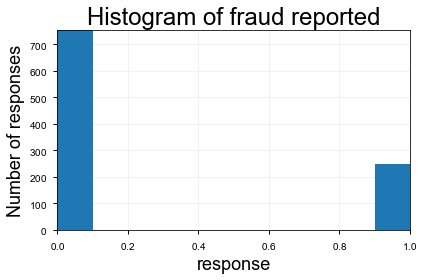

In [5]:
plt.hist(data.fraud_reported)
plt.title("Histogram of fraud reported")
plt.xlabel("response")
plt.ylabel("Number of responses")

- Imbalanced prediction outcome class

In [6]:
# list(data.columns) 
data.head()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_year,fraud_reported
0,328,48,521585,1000,1406.91,0,466132,MALE,MD,craft-repair,...,1,2,YES,71610,6510,13020,52080,Saab,2004,1
1,228,42,342868,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,...,0,0,NaN,5070,780,780,3510,Mercedes,2007,1
2,134,29,687698,2000,1413.14,5000000,430632,FEMALE,PhD,sales,...,2,3,NO,34650,7700,3850,23100,Dodge,2007,0
3,256,41,227811,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,...,1,2,NO,63400,6340,6340,50720,Chevrolet,2014,1
4,228,44,367455,1000,1583.91,6000000,610706,MALE,Associate,sales,...,0,1,NO,6500,1300,650,4550,Accura,2009,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_deductable            1000 non-null   int64  
 4   policy_annual_premium        1000 non-null   float64
 5   umbrella_limit               1000 non-null   int64  
 6   insured_zip                  1000 non-null   int64  
 7   insured_sex                  1000 non-null   object 
 8   insured_education_level      1000 non-null   object 
 9   insured_occupation           1000 non-null   object 
 10  insured_hobbies              1000 non-null   object 
 11  insured_relationship         1000 non-null   object 
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

## Preprocessing

In [8]:
#instantiate both packages to use
encoder = OrdinalEncoder()
knn_imputer = KNN()
MICE_imputer = IterativeImputer()
# create a list of categorical columns to iterate over
col_list = ['insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'property_damage', 'police_report_available', 'auto_make']

impute_df = data

x_data = data.iloc[:,:-1]
y_data = data.iloc[:, -1]

x_impute_df = impute_df.iloc[:,:-1]
y_impute_df = impute_df.iloc[:, -1]

def encode(inport):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(inport.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    inport.loc[inport.notnull()] = np.squeeze(impute_ordinal)
    return inport

#create a for loop to iterate through each column in the data
for columns in col_list:
    encode(x_impute_df[columns])
x_impute_df.head(10)

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_year
0,328,48,521585,1000,1406.91,0,466132,1.0,4.0,2.0,...,1,1,2,1,71610,6510,13020,52080,10.0,2004
1,228,42,342868,2000,1197.22,5000000,468176,1.0,4.0,6.0,...,NaN,0,0,NaN,5070,780,780,3510,8.0,2007
2,134,29,687698,2000,1413.14,5000000,430632,0.0,6.0,11.0,...,0,2,3,0,34650,7700,3850,23100,4.0,2007
3,256,41,227811,2000,1415.74,6000000,608117,0.0,6.0,1.0,...,NaN,1,2,0,63400,6340,6340,50720,3.0,2014
4,228,44,367455,1000,1583.91,6000000,610706,1.0,0.0,11.0,...,0,0,1,0,6500,1300,650,4550,0.0,2009
5,256,39,104594,1000,1351.10,0,478456,0.0,6.0,12.0,...,0,0,2,0,64100,6410,6410,51280,10.0,2003
6,137,34,413978,1000,1333.35,0,441716,1.0,6.0,9.0,...,NaN,0,0,NaN,78650,21450,7150,50050,9.0,2012
7,165,37,429027,1000,1137.03,0,603195,1.0,0.0,12.0,...,NaN,2,2,1,51590,9380,9380,32830,1.0,2015
8,27,33,485665,500,1442.99,0,601734,0.0,6.0,7.0,...,0,1,1,1,27700,2770,2770,22160,12.0,2012
9,212,42,636550,500,1315.68,0,600983,1.0,6.0,8.0,...,0,2,1,NaN,42300,4700,4700,32900,10.0,1996


In [9]:
x_impute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_deductable            1000 non-null   int64  
 4   policy_annual_premium        1000 non-null   float64
 5   umbrella_limit               1000 non-null   int64  
 6   insured_zip                  1000 non-null   int64  
 7   insured_sex                  1000 non-null   float64
 8   insured_education_level      1000 non-null   float64
 9   insured_occupation           1000 non-null   float64
 10  insured_hobbies              1000 non-null   float64
 11  insured_relationship         1000 non-null   float64
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

- Missing data imputation using Fancyimpute library

In [10]:
# impute data and convert 
x_encode_data = pd.DataFrame(np.round(knn_imputer.fit_transform(x_impute_df)),columns = x_impute_df.columns)
logreg = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_val_score(logreg, x_encode_data, y_impute_df, cv=10)
scores.mean()

Imputing row 1/1000 with 0 missing, elapsed time: 0.336
Imputing row 101/1000 with 1 missing, elapsed time: 0.339
Imputing row 201/1000 with 1 missing, elapsed time: 0.343
Imputing row 301/1000 with 1 missing, elapsed time: 0.346
Imputing row 401/1000 with 0 missing, elapsed time: 0.348
Imputing row 501/1000 with 1 missing, elapsed time: 0.351
Imputing row 601/1000 with 1 missing, elapsed time: 0.353
Imputing row 701/1000 with 1 missing, elapsed time: 0.355
Imputing row 801/1000 with 1 missing, elapsed time: 0.358
Imputing row 901/1000 with 0 missing, elapsed time: 0.361


0.78

In [11]:
x_encode_data.head(10)

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_year
0,328.0,48.0,521585.0,1000.0,1407.0,0.0,466132.0,1.0,4.0,2.0,...,1.0,1.0,2.0,1.0,71610.0,6510.0,13020.0,52080.0,10.0,2004.0
1,228.0,42.0,342868.0,2000.0,1197.0,5000000.0,468176.0,1.0,4.0,6.0,...,0.0,0.0,0.0,0.0,5070.0,780.0,780.0,3510.0,8.0,2007.0
2,134.0,29.0,687698.0,2000.0,1413.0,5000000.0,430632.0,0.0,6.0,11.0,...,0.0,2.0,3.0,0.0,34650.0,7700.0,3850.0,23100.0,4.0,2007.0
3,256.0,41.0,227811.0,2000.0,1416.0,6000000.0,608117.0,0.0,6.0,1.0,...,0.0,1.0,2.0,0.0,63400.0,6340.0,6340.0,50720.0,3.0,2014.0
4,228.0,44.0,367455.0,1000.0,1584.0,6000000.0,610706.0,1.0,0.0,11.0,...,0.0,0.0,1.0,0.0,6500.0,1300.0,650.0,4550.0,0.0,2009.0
5,256.0,39.0,104594.0,1000.0,1351.0,0.0,478456.0,0.0,6.0,12.0,...,0.0,0.0,2.0,0.0,64100.0,6410.0,6410.0,51280.0,10.0,2003.0
6,137.0,34.0,413978.0,1000.0,1333.0,0.0,441716.0,1.0,6.0,9.0,...,1.0,0.0,0.0,0.0,78650.0,21450.0,7150.0,50050.0,9.0,2012.0
7,165.0,37.0,429027.0,1000.0,1137.0,0.0,603195.0,1.0,0.0,12.0,...,1.0,2.0,2.0,1.0,51590.0,9380.0,9380.0,32830.0,1.0,2015.0
8,27.0,33.0,485665.0,500.0,1443.0,0.0,601734.0,0.0,6.0,7.0,...,0.0,1.0,1.0,1.0,27700.0,2770.0,2770.0,22160.0,12.0,2012.0
9,212.0,42.0,636550.0,500.0,1316.0,0.0,600983.0,1.0,6.0,8.0,...,0.0,2.0,1.0,0.0,42300.0,4700.0,4700.0,32900.0,10.0,1996.0


In [12]:
x_impute_df = pd.DataFrame(np.round(MICE_imputer.fit_transform(x_impute_df)),columns = x_impute_df.columns)
scores = cross_val_score(logreg, x_impute_df, y_impute_df, cv=10)
scores.mean()

0.791

In [13]:
x_impute_df.head(10)

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,...,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_year
0,328.0,48.0,521585.0,1000.0,1407.0,0.0,466132.0,1.0,4.0,2.0,...,1.0,1.0,2.0,1.0,71610.0,6510.0,13020.0,52080.0,10.0,2004.0
1,228.0,42.0,342868.0,2000.0,1197.0,5000000.0,468176.0,1.0,4.0,6.0,...,0.0,0.0,0.0,0.0,5070.0,780.0,780.0,3510.0,8.0,2007.0
2,134.0,29.0,687698.0,2000.0,1413.0,5000000.0,430632.0,0.0,6.0,11.0,...,0.0,2.0,3.0,0.0,34650.0,7700.0,3850.0,23100.0,4.0,2007.0
3,256.0,41.0,227811.0,2000.0,1416.0,6000000.0,608117.0,0.0,6.0,1.0,...,0.0,1.0,2.0,0.0,63400.0,6340.0,6340.0,50720.0,3.0,2014.0
4,228.0,44.0,367455.0,1000.0,1584.0,6000000.0,610706.0,1.0,0.0,11.0,...,0.0,0.0,1.0,0.0,6500.0,1300.0,650.0,4550.0,0.0,2009.0
5,256.0,39.0,104594.0,1000.0,1351.0,0.0,478456.0,0.0,6.0,12.0,...,0.0,0.0,2.0,0.0,64100.0,6410.0,6410.0,51280.0,10.0,2003.0
6,137.0,34.0,413978.0,1000.0,1333.0,0.0,441716.0,1.0,6.0,9.0,...,1.0,0.0,0.0,1.0,78650.0,21450.0,7150.0,50050.0,9.0,2012.0
7,165.0,37.0,429027.0,1000.0,1137.0,0.0,603195.0,1.0,0.0,12.0,...,0.0,2.0,2.0,1.0,51590.0,9380.0,9380.0,32830.0,1.0,2015.0
8,27.0,33.0,485665.0,500.0,1443.0,0.0,601734.0,0.0,6.0,7.0,...,0.0,1.0,1.0,1.0,27700.0,2770.0,2770.0,22160.0,12.0,2012.0
9,212.0,42.0,636550.0,500.0,1316.0,0.0,600983.0,1.0,6.0,8.0,...,0.0,2.0,1.0,1.0,42300.0,4700.0,4700.0,32900.0,10.0,1996.0


- Cross validation of data for effeective training

In [14]:
x_impute_train_df, x_impute_test_df, y_impute_train_df, y_impute_test_df = train_test_split(x_impute_df,
                                                                                    y_impute_df,
                                                                                    test_size=0.3, random_state=73)

- For class imbalance in the data, we use Synthetic Minority Oversampling Technique [SMOTE] oversampling of minority class  through the K nearest neighbors on data points.

In [15]:
sm = SMOTE(random_state=24)
x_impute_train_df, y_impute_train_df = sm.fit_resample(x_impute_train_df, y_impute_train_df)

x_impute_train_df = pd.DataFrame(x_impute_train_df, columns=x_impute_df.columns)
y_impute_train_df = pd.Series(y_impute_train_df)

model_preds = {}

## Training and Evaluation

### Logistic Regression

Results on testing data:
Accuracy = 0.57
Precision = 0.5945945945945946
Recall = 0.3076923076923077

AUC value = 0.5583047525722686


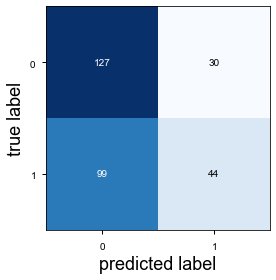

In [16]:
model = LogisticRegression()
model.fit(x_impute_train_df, y_impute_train_df)

predictions_train = model.predict(x_impute_train_df)
predictions_test = model.predict(x_impute_test_df)


conf_matrix = confusion_matrix(predictions_test, y_impute_test_df)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, y_impute_test_df)
recall = recall_score(predictions_test, y_impute_test_df)

print("=========================================")
print("Results on testing data:")
print("=========================================")
print("Accuracy = "+str(accuracy_score(predictions_test, y_impute_test_df)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, y_impute_test_df, pos_label=1)
model_preds["Logistic Regression"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

### K Nearest Neighbors

Results on testing data:
Accuracy = 0.58
Precision = 0.44594594594594594
Recall = 0.2796610169491525

AUC value = 0.5271931458372137


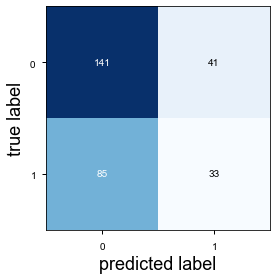

In [17]:
knn = KNeighborsClassifier()
knn.fit(x_impute_train_df, y_impute_train_df)

predictions_train = knn.predict(x_impute_train_df)
predictions_test = knn.predict(x_impute_test_df)

conf_matrix = confusion_matrix(predictions_test, y_impute_test_df)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, y_impute_test_df)
recall = recall_score(predictions_test, y_impute_test_df)

print("=========================================")
print("Results on testing data:")
print("=========================================")
print("Accuracy = "+str(accuracy_score(predictions_test, y_impute_test_df)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, y_impute_test_df, pos_label=1)
model_preds["K Nearest Neighbor"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

### Decision Trees

Results on testing data:
Accuracy = 0.78
Precision = 0.6351351351351351
Recall = 0.5465116279069767

AUC value = 0.7101717018039557


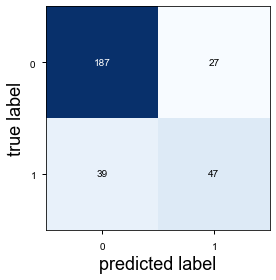

In [18]:
tree = DecisionTreeClassifier()
tree.fit(x_impute_train_df, y_impute_train_df)

predictions_train = tree.predict(x_impute_train_df)
predictions_test = tree.predict(x_impute_test_df)


conf_matrix = confusion_matrix(predictions_test, y_impute_test_df)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, y_impute_test_df)
recall = recall_score(predictions_test, y_impute_test_df)

print("=========================================")
print("Results on testing data:")
print("=========================================")
print("Accuracy = "+str(accuracy_score(predictions_test, y_impute_test_df)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, y_impute_test_df, pos_label=1)
model_preds["Decision Tree"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

### Random Forest Classifier

Results on testing data:
Accuracy = 0.7766666666666666
Precision = 0.4864864864864865
Recall = 0.5538461538461539

AUC value = 0.6960720130932897


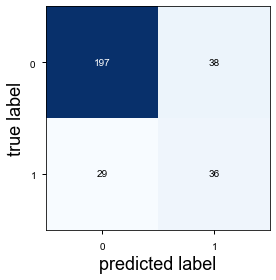

In [19]:
random_forest = RandomForestClassifier()
random_forest.fit(x_impute_train_df, y_impute_train_df)

predictions_train = random_forest.predict(x_impute_train_df)
predictions_test = random_forest.predict(x_impute_test_df)


conf_matrix = confusion_matrix(predictions_test, y_impute_test_df)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, y_impute_test_df)
recall = recall_score(predictions_test, y_impute_test_df)

print("=========================================")
print("Results on testing data:")
print("=========================================")
print("Accuracy = "+str(accuracy_score(predictions_test, y_impute_test_df)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, y_impute_test_df, pos_label=1)
model_preds["Random Forest"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

### Linear Discriminant Analysis

Results on testing data:
Accuracy = 0.6833333333333333
Precision = 0.7027027027027027
Recall = 0.416

AUC value = 0.6451428571428571


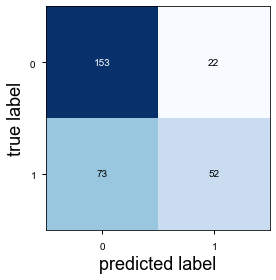

In [20]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_impute_train_df, y_impute_train_df)

predictions_train = lda.predict(x_impute_train_df)
predictions_test = lda.predict(x_impute_test_df)


conf_matrix = confusion_matrix(predictions_test, y_impute_test_df)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, y_impute_test_df)
recall = recall_score(predictions_test, y_impute_test_df)

print("=========================================")
print("Results on testing data:")
print("=========================================")
print("Accuracy = "+str(accuracy_score(predictions_test, y_impute_test_df)))
print("Precision = "+str(precision_score(predictions_test, y_impute_test_df)))
print("Recall = "+str(recall_score(predictions_test, y_impute_test_df)))

tpr, fpr, threshold = roc_curve(predictions_test, y_impute_test_df, pos_label=1)
model_preds["Linear Discriminant Analysis"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

In [21]:
# SVC(kernel = 'rbf', degree = 3, gamma = 'auto', coef0 = 0.0, C = 1.0, tol = 0.001, probability = False, class_weight = None, shrinking = False, cache_size = None, verbose = False, max_iter = -1, n_jobs = -1, max_mem_size = -1, random_state = None, decision_function_shape = 'ovo')
# param_grid = {'C': [0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'sigmoid', 'rbf', 'poly'], 'random_state': [3333],}
# clf_grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
# clf_grid.fit(x_impute_train_df_, y_impute_train_df)
# print(clf_grid.best_estimator_)

### Support Vector Machine

RBF Kernel Normalized Fit Time: 0.1087 s


Results on testing data:
Accuracy = 0.7266666666666667
Precision = 0.7140636211432672
Recall = 0.6712918660287082

AUC value = 0.671291866028708


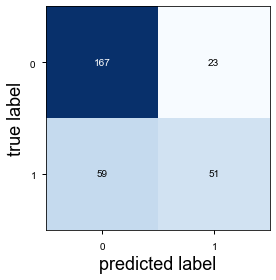

In [29]:
#Create a svm Classifier
scaler = MinMaxScaler()  # Default behavior is to scale to [0,1]
x_impute_train_df_ = scaler.fit_transform(x_impute_train_df)
x_impute_test_df_ = scaler.fit_transform(x_impute_test_df)

start = time()
clf = svm.SVC(kernel='rbf', degree = 1, C=1000, gamma=0.001, random_state = 3333) 
clf.fit(x_impute_train_df_, y_impute_train_df)
print("RBF Kernel Normalized Fit Time: {:.4f} s".format(time() - start))

predictions_train = clf.predict(x_impute_train_df_)
predictions_test = clf.predict(x_impute_test_df_)


conf_matrix = confusion_matrix(predictions_test, y_impute_test_df)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, y_impute_test_df)
recall = recall_score(predictions_test, y_impute_test_df)

print("\n")
print("=========================================")
print("Results on testing data:")
print("=========================================")
print("Accuracy = "+str(accuracy_score(predictions_test, y_impute_test_df)))
print("Precision = "+str(precision_score(predictions_test, y_impute_test_df, average="macro")))
print("Recall = "+str(recall_score(predictions_test, y_impute_test_df, average="macro")))

tpr, fpr, threshold = roc_curve(predictions_test, y_impute_test_df, pos_label=1)
model_preds["Support Vector Machine"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

### Receiving Operator Charecteristic

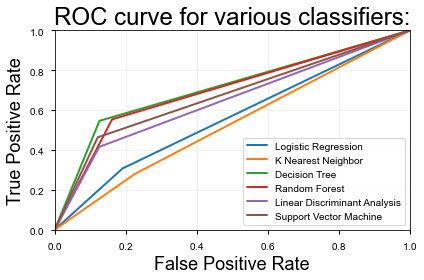

In [23]:
plt.title("ROC curve for various classifiers:")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for key, value in model_preds.items():
    model_list = model_preds[key]
    plt.plot(model_list[0], model_list[1], label=key)
    plt.legend()
plt.show()

- As we can see from the above ROC curves and results, Decision Tree and Random Forests are performing well when compared to all other classifiers.
- KNN is performing the worst out of all the classifiers.
- I was hoping to get better results with Support Vector Machine but with this size of the data I am not surprised with this result. 

In [24]:
# Save the model as a pickle in a file 
class model_wts:
    def __init__(self, model):
        self.model = model

    def _predict(self, inport):
        return self.model.predict(inport)

    def save(self, filename):
        self.filename = filename
        joblib.dump(self.model, self.filename)

    def load(self):
        trained_model = joblib.load(self.filename)
        return trained_model 


In [25]:
model_s = model_wts(tree)
# model_s.save('./model_weight/deci_tree.pkl')

In [67]:
i = x_impute_test_df.iloc[:1].to_dict(orient='list')
i = {k:v[0] for k,v in i.items()}
i

{'months_as_customer': 59.0,
 'age': 40.0,
 'policy_number': 444422.0,
 'policy_deductable': 2000.0,
 'policy_annual_premium': 782.0,
 'umbrella_limit': 0.0,
 'insured_zip': 449221.0,
 'insured_sex': 1.0,
 'insured_education_level': 1.0,
 'insured_occupation': 10.0,
 'insured_hobbies': 9.0,
 'insured_relationship': 2.0,
 'capital-gains': 64200.0,
 'capital-loss': -32300.0,
 'incident_type': 0.0,
 'collision_type': 0.0,
 'incident_severity': 2.0,
 'authorities_contacted': 0.0,
 'incident_hour_of_the_day': 0.0,
 'number_of_vehicles_involved': 3.0,
 'property_damage': 0.0,
 'bodily_injuries': 0.0,
 'witnesses': 2.0,
 'police_report_available': 0.0,
 'total_claim_amount': 51570.0,
 'injury_claim': 5730.0,
 'property_claim': 11460.0,
 'vehicle_claim': 34380.0,
 'auto_make': 2.0,
 'auto_year': 2010.0}

In [75]:
model_s._predict(np.array(list(i.values())).reshape(1,-1))

array([0])